In [7]:
import logging, tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader

import copy
import time, yaml
import torch.nn.functional as F
import pandas as pd, numpy as np
pd.options.mode.chained_assignment = None

from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt

from evml.plotting import plot_confusion_matrix, conus_plot
from evml.reliability import reliability_diagram, reliability_diagrams, compute_calibration

In [5]:
config = "../results/echo/best.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

FileNotFoundError: [Errno 2] No such file or directory: '../results/echo/best.yml'

In [3]:
outputs = conf["outputvars"]
save_loc = conf['save_loc']

In [4]:
train_data = pd.read_parquet(f"{save_loc}/train.parquet")
valid_data = pd.read_parquet(f"{save_loc}/valid.parquet")
test_data = pd.read_parquet(f"{save_loc}/test.parquet")

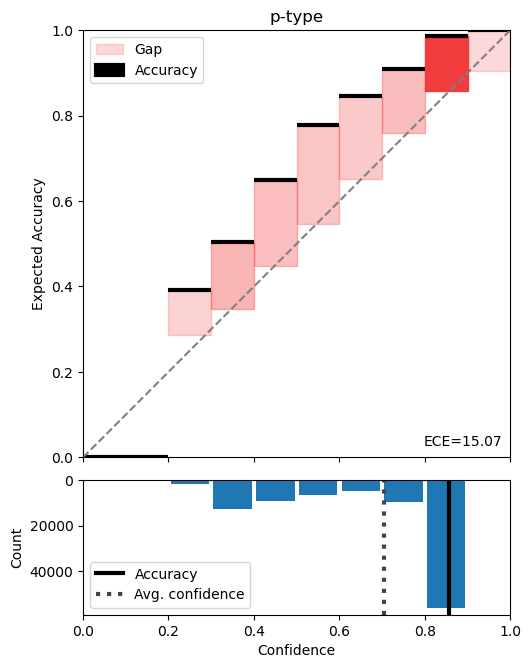

In [5]:
title = "p-type"
fig = reliability_diagram(
    test_data["true_labels"].to_numpy(), 
    test_data["pred_labels"].to_numpy(), 
    test_data["pred_conf"].to_numpy(), 
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100, 
    return_fig=True)

In [6]:
cond0 = (test_data["true_labels"] == 0)
cond1 = (test_data["true_labels"] == 1)
cond2 = (test_data["true_labels"] == 2)
cond3 = (test_data["true_labels"] == 3)

results = OrderedDict()
results[outputs[0]] = {
    "true_labels": test_data[cond0]["true_labels"].values, 
    "pred_labels": test_data[cond0]["pred_labels"].values, 
    "confidences": test_data[cond0]["pred_conf"].values
}
results[outputs[1]] = {
    "true_labels": test_data[cond1]["true_labels"].values, 
    "pred_labels": test_data[cond1]["pred_labels"].values, 
    "confidences": test_data[cond1]["pred_conf"].values
}
results[outputs[2]] = {
    "true_labels": test_data[cond2]["true_labels"].values, 
    "pred_labels": test_data[cond2]["pred_labels"].values, 
    "confidences": test_data[cond2]["pred_conf"].values
}
results[outputs[3]] = {
    "true_labels": test_data[cond3]["true_labels"].values, 
    "pred_labels": test_data[cond3]["pred_labels"].values, 
    "confidences": test_data[cond3]["pred_conf"].values
}

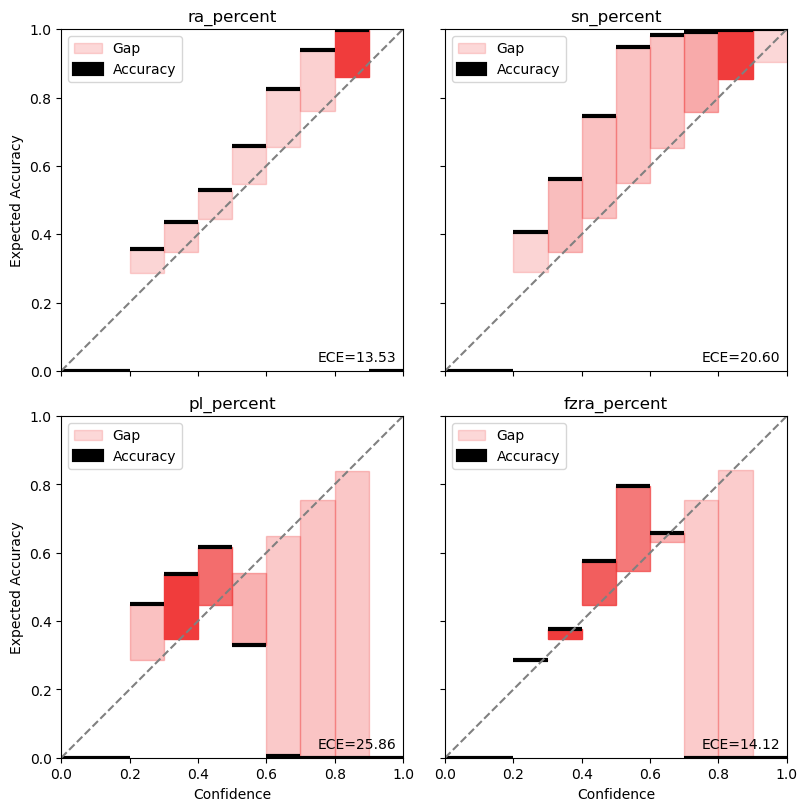

In [7]:
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

In [2]:
plot_confusion_matrix(test_data["true_label"], 
                      test_data["pred_label"], 
                      ["rain", "snow", "sleet", "frz rain"], 
                      "MLP", 
                      normalize=True,
                      title=f'Confusion Matrix (normalized)')#, filename='cm_norm.png')

plt.show()

NameError: name 'test_data' is not defined

In [8]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

In [9]:
test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

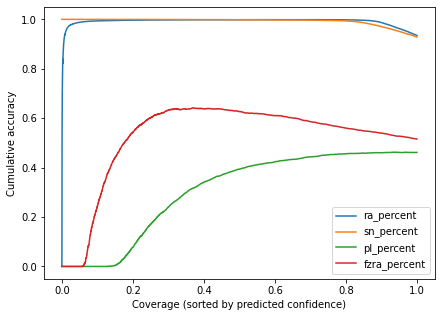

In [10]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.legend(outputs)
plt.show()

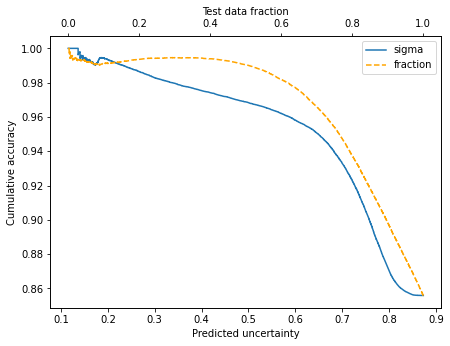

In [11]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

test_data_sorted = compute_cov(test_data, col = "uncertainty", quan = "acc", ascending = True)

l1, = ax.plot(
    test_data_sorted["uncertainty"],
    test_data_sorted["cu_acc"],
    label = "sigma"
)

ax2 = ax.twiny()
l2, = ax2.plot(
    test_data_sorted["uncertainty_cov"],
    test_data_sorted["cu_acc"], 
    color='orange', ls = "--", 
    label = "fraction")

ax.set_ylabel("Cumulative accuracy")
ax2.set_xlabel("Test data fraction")
ax.set_xlabel("Predicted uncertainty")

plt.legend([l1, l2], ["sigma", "fraction"])

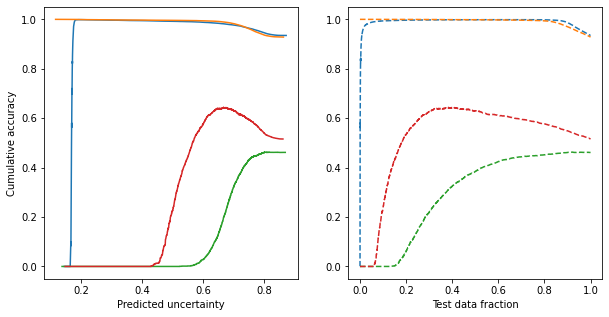

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='col')

for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax[0].plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax[1].plot(
        _test_data_sorted["uncertainty_cov"],
        _test_data_sorted["cu_acc"],
        ls = "--"
    )
    
ax[0].set_ylabel("Cumulative accuracy")
#ax[0].set_xlabel("Coverage (sorted by predicted uncertainty)")

ax[1].set_xlabel("Test data fraction")
ax[0].set_xlabel("Predicted uncertainty")


plt.show()

### [STOPPED HERE] Case study (need to remove the holdout days from the training dataset before splitting) 

In [45]:
import glob, joblib
from cartopy import crs as ccrs
from cartopy import feature as cfeature

In [46]:
with open(f"{save_loc}/scalers.pkl", "rb") as fid:
    scaler_x = joblib.load(fid)

In [47]:
for d in [3,4,5,6,7,8]:
    t1 = train_data["datetime"].apply(lambda x: True if f"2021-02-1{d}" in str(x) else False).sum()
    t2 = valid_data["datetime"].apply(lambda x: True if f"2021-02-1{d}" in str(x) else False).sum()
    t3 = test_data["datetime"].apply(lambda x: True if f"2021-02-1{d}" in str(x) else False).sum()
    print(d, t1, t2, t3)

NameError: name 'train_data' is not defined

In [38]:
arr = sorted(glob.glob("/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/*"))
days = [d for d in arr if ("20210213" in d) or ("20210214" in d) 
        or ("20210215" in d) or ("20210216" in d) or ("20210217" in d) or ("20210218" in d)]
df_asos = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(days)])
## Select observations over and adjacent to Oklahoma
df_na_asos = df_asos[(df_asos["lat"] <= 50.0) & (df_asos["lat"] >= 24.0) & 
                   (df_asos["lon"] <= -63.0) & (df_asos["lon"] >= -117.0)]

100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


In [39]:
df_na_asos.shape

(24913, 407)

In [ ]:
total_df = pd.concat([train_data, valid_data, test_data], axis = 1)

In [ ]:
total_df.columns

In [52]:
df_na_asos

,datetime,lat,lon,report_count,ra_percent,sn_percent,pl_percent,fzra_percent,CFRZR_-,CICEP_-,...,VVEL_775_Pa/s,VVEL_800_Pa/s,VVEL_825_Pa/s,VVEL_850_Pa/s,VVEL_875_Pa/s,VVEL_900_Pa/s,VVEL_925_Pa/s,VVEL_950_Pa/s,VVEL_975_Pa/s,idx
0,2021-02-13 00:00:00,30.205,-91.988,16,0.75,0.25,0.0,0.0,0.0,0.0,...,0.069659,0.051673,0.063828,0.041100,0.015648,-0.005374,0.024016,0.076359,0.099236,"[87, 267]"
1,2021-02-13 00:00:00,30.233,-81.667,9,1.00,0.00,0.0,0.0,0.0,0.0,...,-0.367841,-0.260827,-0.154922,-0.115150,-0.109352,-0.130374,-0.132234,-0.142391,-0.119514,"[91, 341]"
2,2021-02-13 00:00:00,30.336,-81.515,10,1.00,0.00,0.0,0.0,0.0,0.0,...,-0.899091,-0.885827,-0.842422,-0.771400,-0.640602,-0.536624,-0.413484,-0.298641,-0.182014,"[92, 342]"
3,2021-02-13 00:00:00,30.349,-85.788,12,1.00,0.00,0.0,0.0,0.0,0.0,...,0.663409,0.551673,0.345078,0.166100,0.015648,-0.099124,-0.163484,-0.204891,-0.119514,"[90, 312]"
4,2021-02-13 00:00:00,30.400,-81.417,12,1.00,0.00,0.0,0.0,0.0,0.0,...,-1.336591,-1.417077,-1.373672,-1.271400,-1.109352,-0.911624,-0.663484,-0.423641,-0.244514,"[93, 342]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4580,2021-02-18 23:00:00,44.932,-93.056,12,0.00,1.00,0.0,0.0,0.0,0.0,...,-0.012574,0.003822,0.019375,-0.028421,-0.028825,-0.056252,-0.058688,-0.049160,-0.041529,"[211, 258]"
4592,2021-02-18 23:00:00,46.405,-94.131,11,0.00,1.00,0.0,0.0,0.0,0.0,...,-0.106324,-0.089928,-0.043125,-0.028421,0.002425,0.006248,0.035062,0.013340,0.020971,"[224, 251]"
4595,2021-02-18 23:00:00,46.837,-92.183,12,0.00,1.00,0.0,0.0,0.0,0.0,...,-0.043824,-0.058678,-0.043125,-0.059671,-0.060075,-0.056252,-0.027438,0.013340,0.052221,"[228, 263]"
4596,2021-02-18 23:00:00,46.925,-96.811,5,0.00,1.00,0.0,0.0,0.0,0.0,...,0.018676,0.003822,-0.043125,-0.059671,-0.060075,-0.087502,-0.089938,-0.080410,-0.041529,"[228, 235]"


In [50]:
features = features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
case_study_inputs = scaler_x.transform(df_na_asos[features])
case_study_labels = np.argmax(df_na_asos[outputs].to_numpy(), 1)

In [51]:
test_split = TensorDataset(
    torch.from_numpy(case_study_inputs).float(),
    torch.from_numpy(case_study_labels).long()
)
test_loader = DataLoader(test_split, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=0)

NameError: name 'batch_size' is not defined

In [156]:
model.eval()
with torch.no_grad():

    if verbose:
        total = int(np.ceil(len(test_loader.dataset) / batch_size))
        my_iter = tqdm.tqdm(enumerate(test_loader),
                        total = total,
                        leave = True)
    else:
        my_iter = enumerate(test_loader)

    # Iterate over data.
    results_dict = defaultdict(list)
    for i, (inputs, labels) in my_iter:

        inputs = inputs.to(device)
        labels = labels.to(device)

        if use_uncertainty:
            output = model(inputs)
            evidence = relu_evidence(output)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(output, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
            results_dict["pred_uncertainty"].append(uncertainty)

        else:
            output = model(img_variable)
            _, preds = torch.max(output, 1)
            prob = F.softmax(output, dim=1)

        results_dict["pred_labels"].append(preds.unsqueeze(-1))
        results_dict["true_labels"].append(labels.unsqueeze(-1))
        results_dict["pred_probs"].append(prob)

        # statistics
        results_dict["acc"].append(torch.mean((preds == labels.data).float()).item())

        if verbose:
            print_str = f'test_acc: {np.mean(results_dict["acc"]):.4f}'
            my_iter.set_description(print_str)
            my_iter.refresh()

    results_dict["pred_uncertainty"] = torch.cat(results_dict["pred_uncertainty"], 0)
    results_dict["pred_probs"] = torch.cat(results_dict["pred_probs"], 0)
    results_dict["pred_labels"] = torch.cat(results_dict["pred_labels"], 0)
    results_dict["true_labels"] = torch.cat(results_dict["true_labels"], 0)

test_acc: 0.8903: 100%|██████████| 7/7 [00:00<00:00, 25.17it/s]


In [157]:
for idx in range(len(outputs)):
    df_na_asos[f"{outputs[idx]}_conf"] = results_dict["pred_probs"][:, idx].cpu().numpy()
df_na_asos["uncertainty"] = results_dict["pred_uncertainty"][:, 0].cpu().numpy()
df_na_asos["pred_labels"] = results_dict["pred_labels"][:, 0].cpu().numpy()
df_na_asos["true_labels"] = results_dict["true_labels"][:, 0].cpu().numpy()
df_na_asos["pred_conf"] = np.max(results_dict["pred_probs"].cpu().numpy(), 1)

In [158]:
latN = 54.0
latS = 20.0
lonW = -63.0
lonE = -125.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0.5, 1.0, 'ASOS Precipitation Type, NA 2/13-2/18/2021')

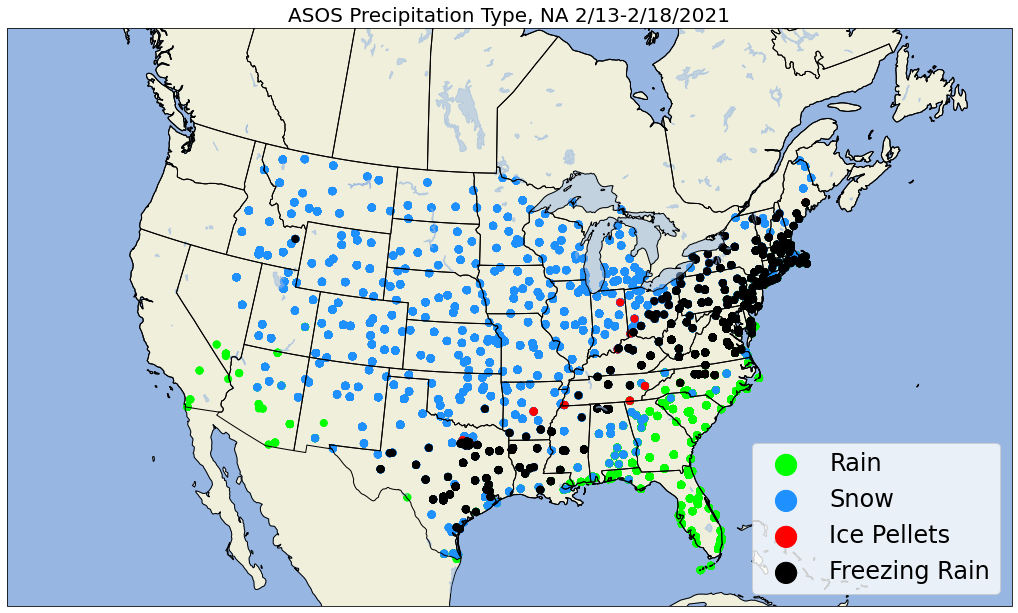

In [159]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df_na_asos["lon"][df_na_asos["true_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["true_labels"] == i],
               c=df_na_asos["true_labels"][df_na_asos["true_labels"] == i].map(colors),
               s=50, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title("ASOS Precipitation Type, NA 2/13-2/18/2021", fontsize=20)

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0.5, 1.0, 'ASOS Precipitation Type, NA 2/13-2/18/2021')

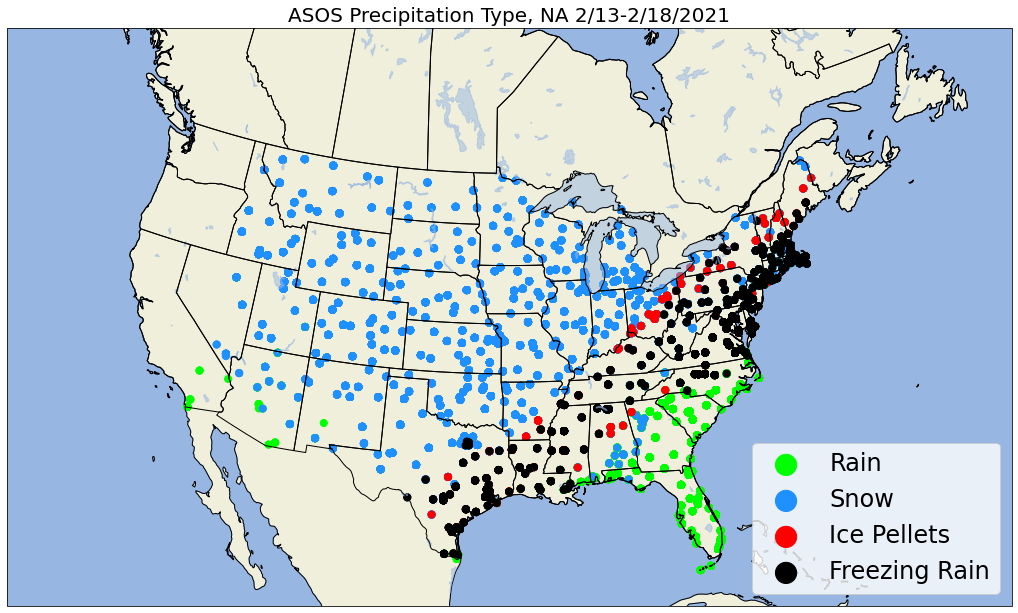

In [160]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["pred_labels"] == i],
               c=df_na_asos["pred_labels"][df_na_asos["pred_labels"] == i].map(colors),
               s=50, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title("ASOS Precipitation Type, NA 2/13-2/18/2021", fontsize=20)

Text(0.5, 1.0, 'ASOS Precipitation Type, NA 2/13-2/18/2021')

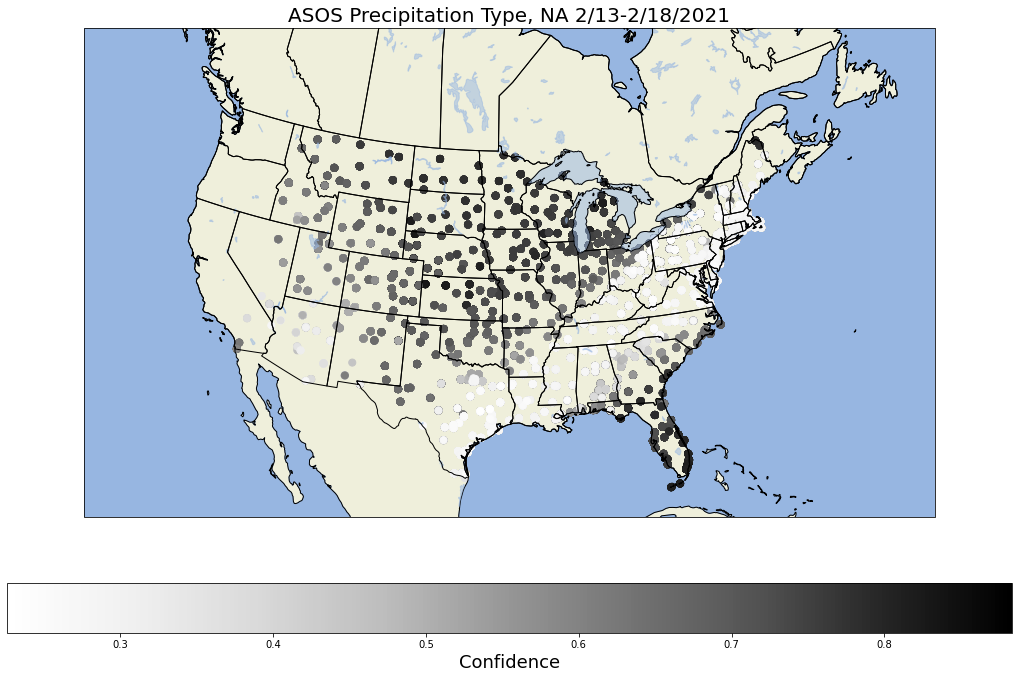

In [161]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["pred_labels"] == i],
               c=df_na_asos["pred_conf"][df_na_asos["pred_labels"] == i],
               s=50, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df_na_asos["pred_conf"].min(), vmax=df_na_asos["pred_conf"].max())

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label('Confidence',size=18)
plt.title("ASOS Precipitation Type, NA 2/13-2/18/2021", fontsize=20)

Text(0.5, 1.0, 'ASOS Precipitation Type, NA 2/13-2/18/2021')

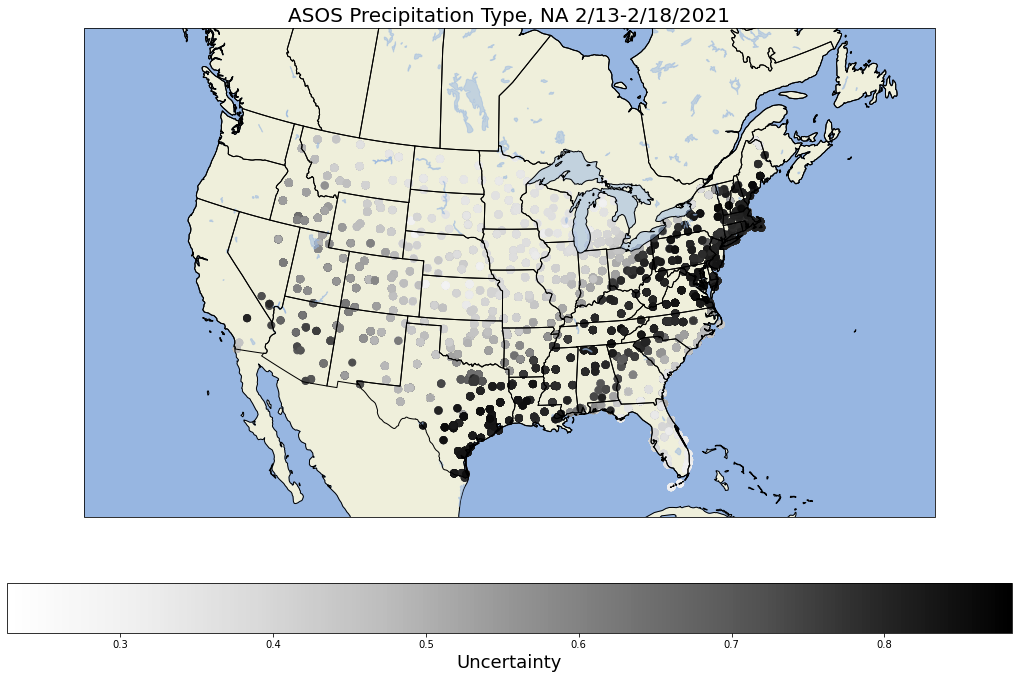

In [162]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    sc = ax.scatter(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["pred_labels"] == i],
               c=df_na_asos["uncertainty"][df_na_asos["pred_labels"] == i],
               s=50, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df_na_asos["uncertainty"].min(), vmax=df_na_asos["uncertainty"].max())

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label('Uncertainty',size=18)
#plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title("ASOS Precipitation Type, NA 2/13-2/18/2021", fontsize=20)

### Oklahoma

In [186]:
for d in [7,8,9]:
    t1 = train_data["datetime"].apply(lambda x: True if f"2015-11-2{d}" in str(x) else False).sum()
    t2 = valid_data["datetime"].apply(lambda x: True if f"2015-11-2{d}" in str(x) else False).sum()
    t3 = test_data["datetime"].apply(lambda x: True if f"2015-11-2{d}" in str(x) else False).sum()
    print(d, t1, t2, t3)

7 622 0 0
8 0 0 467
9 215 0 0


In [163]:
days = [d for d in arr if ("20151127" in d) or ("20151128" in d) or ("20151129" in d)]

In [164]:
df_asos = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(days)])
## Select observations over and adjacent to Oklahoma
df_okla_asos = df_asos[(df_asos["lat"] <= 50.0) & (df_asos["lat"] >= 24.0) & 
                   (df_asos["lon"] <= -63.0) & (df_asos["lon"] >= -117.0)]
case_study_inputs = scaler_x.transform(df_okla_asos[features])
case_study_labels = np.argmax(df_okla_asos[outputs].to_numpy(), 1)

100%|██████████| 3/3 [00:00<00:00,  8.08it/s]


In [165]:
test_split = TensorDataset(
    torch.from_numpy(case_study_inputs).float(),
    torch.from_numpy(case_study_labels).long()
)
test_loader = DataLoader(test_split, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=0)
model.eval()
with torch.no_grad():

    if verbose:
        total = int(np.ceil(len(test_loader.dataset) / batch_size))
        my_iter = tqdm.tqdm(enumerate(test_loader),
                        total = total,
                        leave = True)
    else:
        my_iter = enumerate(test_loader)

    # Iterate over data.
    results_dict = defaultdict(list)
    for i, (inputs, labels) in my_iter:

        inputs = inputs.to(device)
        labels = labels.to(device)

        if use_uncertainty:
            output = model(inputs)
            evidence = relu_evidence(output)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(output, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
            results_dict["pred_uncertainty"].append(uncertainty)

        else:
            output = model(img_variable)
            _, preds = torch.max(output, 1)
            prob = F.softmax(output, dim=1)

        results_dict["pred_labels"].append(preds.unsqueeze(-1))
        results_dict["true_labels"].append(labels.unsqueeze(-1))
        results_dict["pred_probs"].append(prob)

        # statistics
        results_dict["acc"].append(torch.mean((preds == labels.data).float()).item())

        if verbose:
            print_str = f'test_acc: {np.mean(results_dict["acc"]):.4f}'
            my_iter.set_description(print_str)
            my_iter.refresh()

    results_dict["pred_uncertainty"] = torch.cat(results_dict["pred_uncertainty"], 0)
    results_dict["pred_probs"] = torch.cat(results_dict["pred_probs"], 0)
    results_dict["pred_labels"] = torch.cat(results_dict["pred_labels"], 0)
    results_dict["true_labels"] = torch.cat(results_dict["true_labels"], 0)
for idx in range(len(outputs)):
    df_okla_asos[f"{outputs[idx]}_conf"] = results_dict["pred_probs"][:, idx].cpu().numpy()
df_okla_asos["uncertainty"] = results_dict["pred_uncertainty"][:, 0].cpu().numpy()
df_okla_asos["pred_labels"] = results_dict["pred_labels"][:, 0].cpu().numpy()
df_okla_asos["true_labels"] = results_dict["true_labels"][:, 0].cpu().numpy()
df_okla_asos["pred_conf"] = np.max(results_dict["pred_probs"].cpu().numpy(), 1)

test_acc: 0.8936: 100%|██████████| 3/3 [00:00<00:00, 43.17it/s]


In [166]:
latN = 39.0
latS = 31.0
lonW = -106.0
lonE = -90.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0.5, 1.0, 'ASOS Precipitation Type, Oklahoma 11/27-11/28/2015')

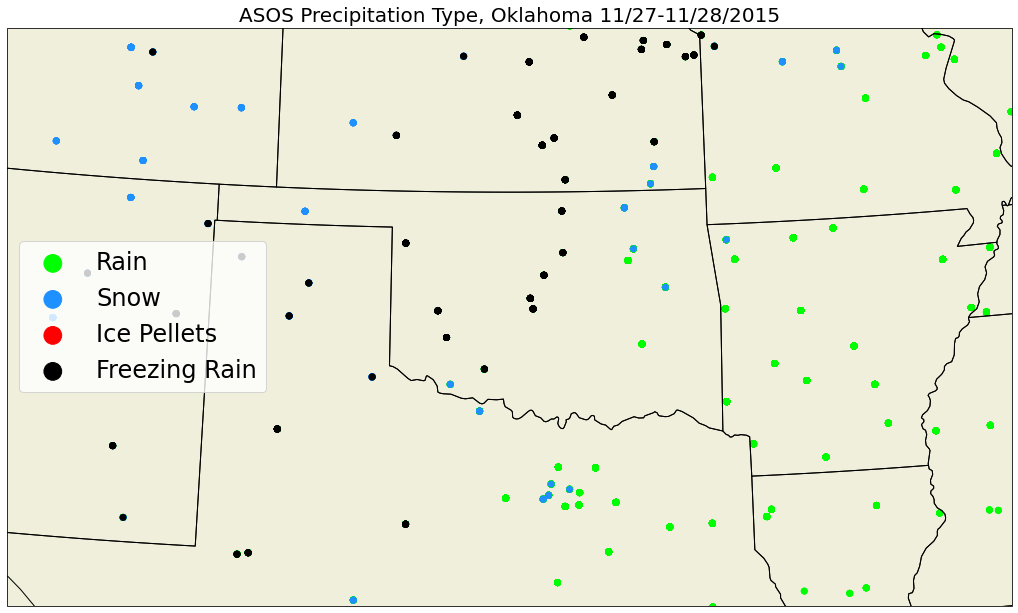

In [167]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df_okla_asos["lon"][df_okla_asos["true_labels"] == i]-360,
               df_okla_asos["lat"][df_okla_asos["true_labels"] == i],
               c=df_okla_asos["true_labels"][df_okla_asos["true_labels"] == i].map(colors),
               s=35, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3)
plt.title("ASOS Precipitation Type, Oklahoma 11/27-11/28/2015", fontsize=20)

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0.5, 1.0, 'ASOS Precipitation Type, Oklahoma 11/27-11/28/2015')

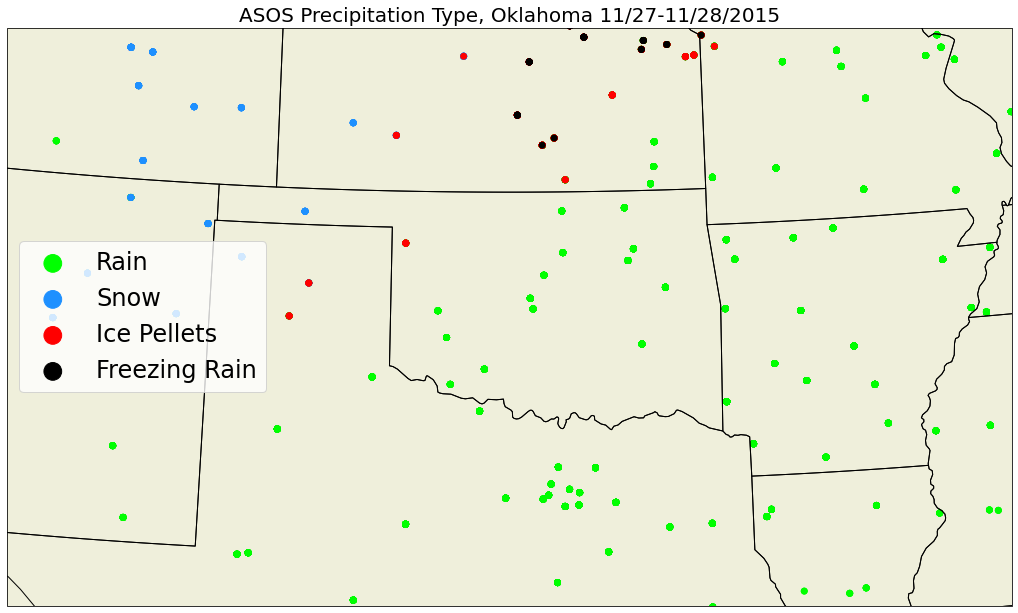

In [168]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df_okla_asos["lon"][df_okla_asos["pred_labels"] == i]-360,
               df_okla_asos["lat"][df_okla_asos["pred_labels"] == i],
               c=df_okla_asos["pred_labels"][df_okla_asos["pred_labels"] == i].map(colors),
               s=35, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3)
plt.title("ASOS Precipitation Type, Oklahoma 11/27-11/28/2015", fontsize=20)

Text(0.5, 1.0, 'ASOS Precipitation Type, Oklahoma 11/27-11/28/2015')

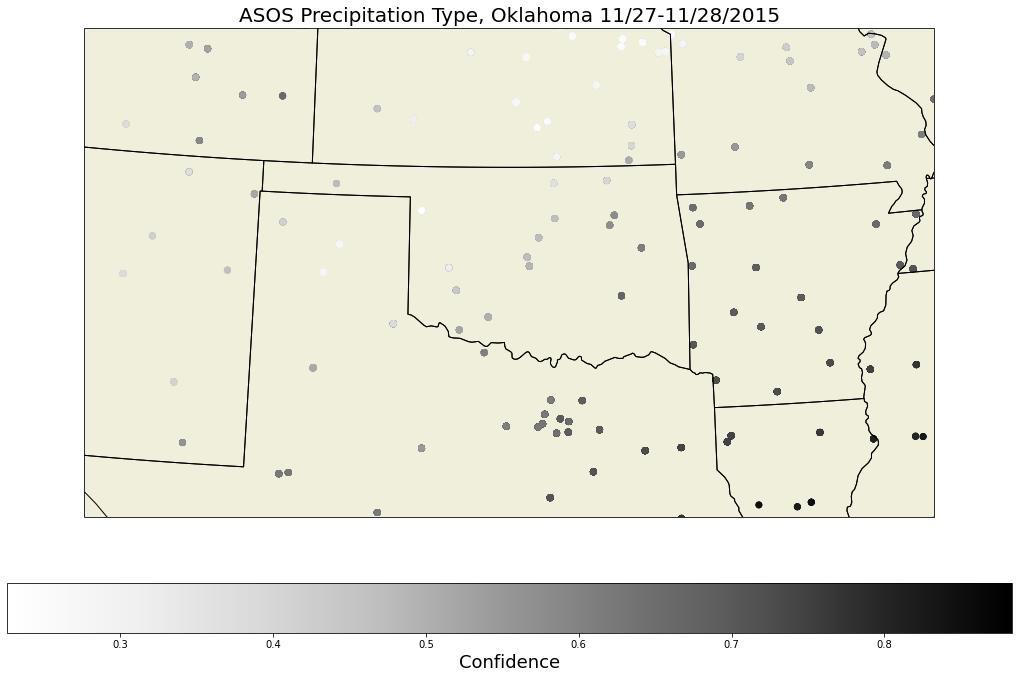

In [169]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    ax.scatter(df_okla_asos["lon"][df_okla_asos["pred_labels"] == i]-360,
               df_okla_asos["lat"][df_okla_asos["pred_labels"] == i],
               c=df_okla_asos["pred_conf"][df_okla_asos["pred_labels"] == i],
               s=35, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df_okla_asos["pred_conf"].min(), vmax=df_okla_asos["pred_conf"].max())
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label('Confidence',size=18)
#plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3)
plt.title("ASOS Precipitation Type, Oklahoma 11/27-11/28/2015", fontsize=20)

Text(0.5, 1.0, 'ASOS Precipitation Type, Oklahoma 11/27-11/28/2015')

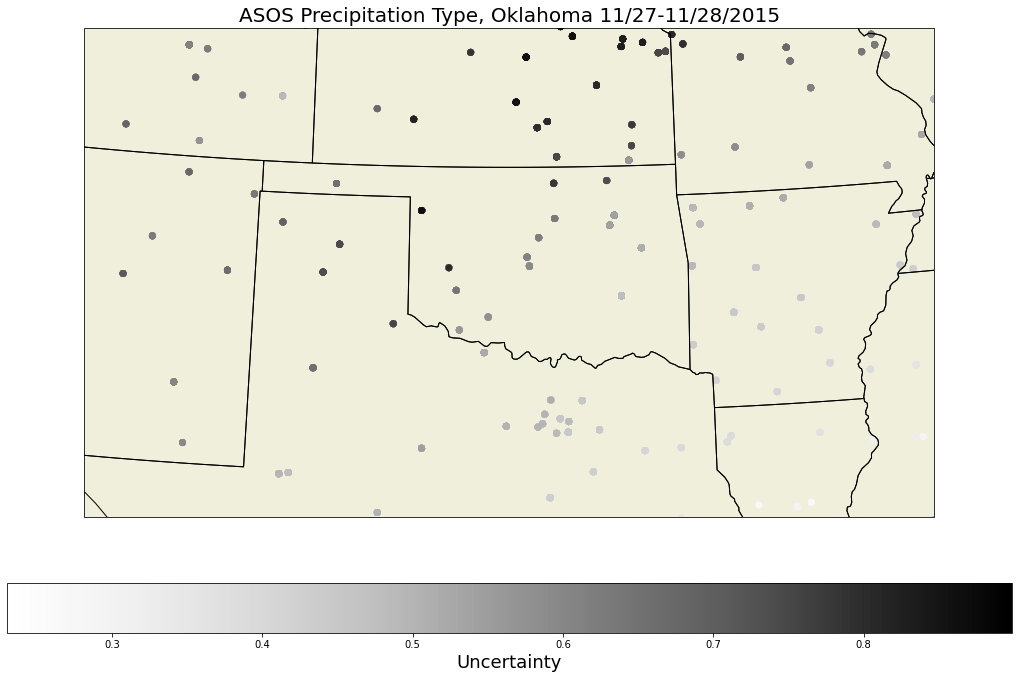

In [170]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(4):
    sc = ax.scatter(df_okla_asos["lon"][df_okla_asos["pred_labels"] == i]-360,
               df_okla_asos["lat"][df_okla_asos["pred_labels"] == i],
               c=df_okla_asos["uncertainty"][df_okla_asos["pred_labels"] == i],
               s=35, transform=ccrs.PlateCarree(), cmap='Greys',
                    vmin=df_okla_asos["uncertainty"].min(), vmax=df_okla_asos["uncertainty"].max())
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label('Uncertainty',size=18)
#plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3)
plt.title("ASOS Precipitation Type, Oklahoma 11/27-11/28/2015", fontsize=20)